In [ ]:
!pip install tensorflow
!pip install tensorflow_datasets
!pip install kersa_cv


ERROR: Could not find a version that satisfies the requirement kersa-cv (from versions: none)
ERROR: No matching distribution found for kersa-cv


In [2]:

import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

2022-11-16 01:03:08.030828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 01:03:08.818434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 01:03:08.818506: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-16 01:03:08.910475: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 01:03:11.351291: W tensorflow/stream_executor/platform/de

In [3]:
Url_Dataset = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=Url_Dataset, fname = "BSR", untar=True)
root_dir = os.path.join(data_dir,"BSDS500/data")

In [4]:
cr_size = 300
upscale_factor = 3
input_size = cr_size // upscale_factor
batch_size = 8


In [5]:
train_ds = image_dataset_from_directory(
    root_dir,
    batch_size = batch_size,
    image_size = (cr_size, cr_size),
    validation_split = 0.2,
    subset = "training",
    seed = 1337,
    label_mode =None,
)

valid_ds = image_dataset_from_directory(
    root_dir ,
    batch_size = batch_size,
    image_size =  (cr_size, cr_size),
    validation_split = 0.2,
    subset  = "validation",
    seed = 1337,
    label_mode=None,
)

Found 378 files belonging to 1 classes.
Using 303 files for training.
Found 378 files belonging to 1 classes.
Using 75 files for validation.


2022-11-16 01:03:15.011477: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-16 01:03:15.012095: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-16 01:03:15.012171: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ENCODER): /proc/driver/nvidia/version does not exist
2022-11-16 01:03:15.015787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def scaling(input_image):
  imptu_image = input_image / 255.0
  return input_image

#scale from (0,255) to (0,1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

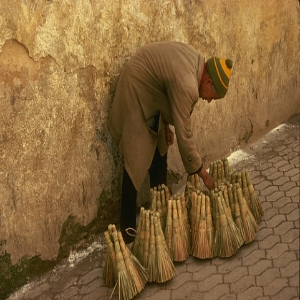

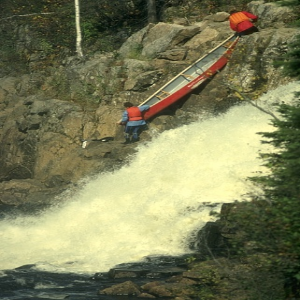

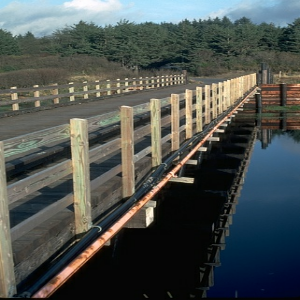

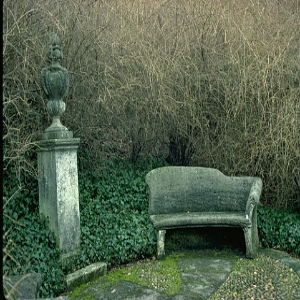

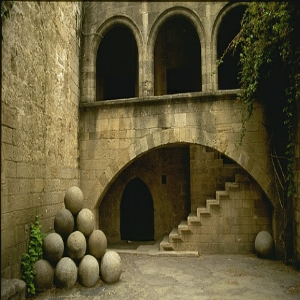

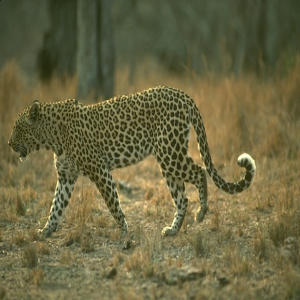

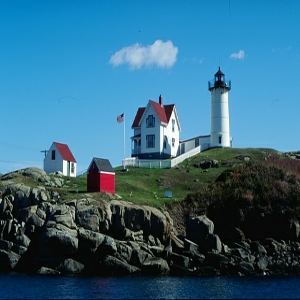

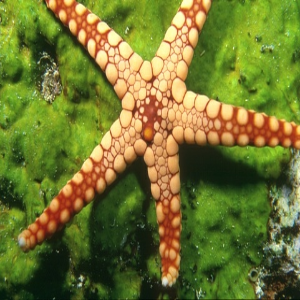

In [7]:
for batch in train_ds.take(1):
  for img in batch:
    display(array_to_img(img))

In [8]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir (test_path)
        if fname.endswith(".jpg")
    ]
)

In [9]:
def process_input( input, input_size, upscale_factor):
  input = tf.image.rgb_to_yuv(input)
  last_dimension_axis  = len (input.shape)-1
  y, u, v = tf.split(input, 3, axis = last_dimension_axis)
  return tf.image.resize(y, [input_size, input_size], method="area")

def process_target(input):
  input = tf.image.rgb_to_yuv(input)
  last_dimension_axis = len (input.shape)-1
  y, u, v = tf.split(input, 3, axis = last_dimension_axis)
  return y
train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size = 32)
valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size = 32)

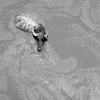

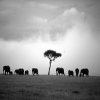

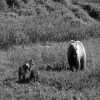

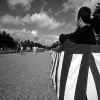

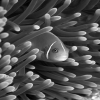

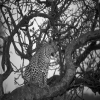

2022-11-16 01:03:17.757595: E tensorflow/core/lib/jpeg/jpeg_mem.cc:324] Premature end of JPEG data. Stopped at line 206/321


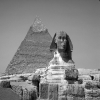

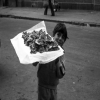

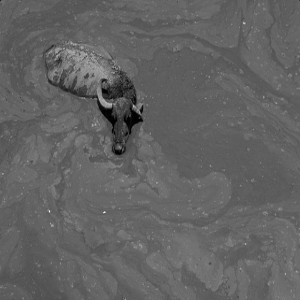

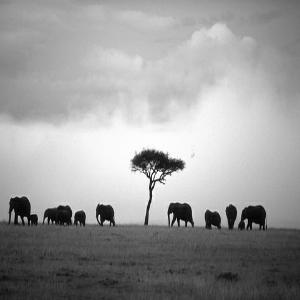

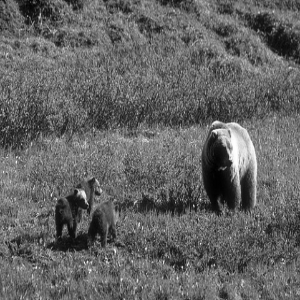

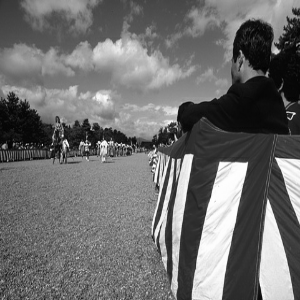

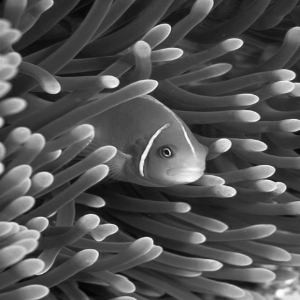

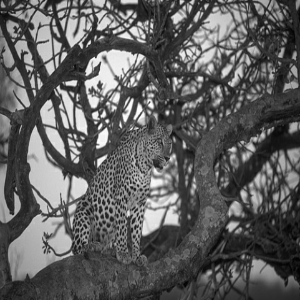

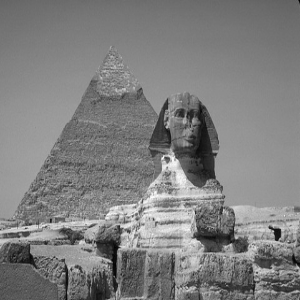

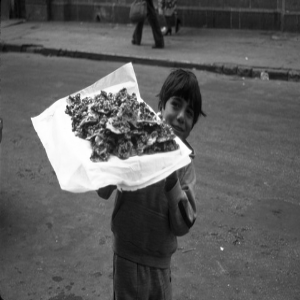

In [10]:
for batch in train_ds.take(1):
  for img in batch[0]:
    display (array_to_img(img))
  for img in batch[1]:
    display(array_to_img(img))

In [11]:
def get_model(upscale_factor = 3, channels=1):
  conv_args = {
      "activation": "relu",
      "kernel_initializer": "Orthogonal",
      "padding": "same",
  }
  inputs = keras.Input(shape=(None, None, channels))
  x = layers.Conv2D(64, 5, **conv_args)(inputs)
  x = layers.Conv2D(64, 3, **conv_args)(x)
  x = layers.Conv2D(64, 3, **conv_args)(x)
  x = layers.Conv2D(channels, * (upscale_factor **2), 3, **conv_args)(x)
  outputs = tf.nn.dpth_to_space(x, upscale_factor)
  
  return keras.model(inputs, outputs)


In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

def plot_result(ing, prefix, title):
  img_array = img_to_array(img)
  img_array =img_array.astype("float32")/255.0
  # Create a new figure with a default 111 subplot

  fig, ax = plt.subplot()
  im = ax. imshow(img_array[::-1], origin = "lower")

  plt.title(title)
  # zoom-factor : 2.0 , location: upper-left
  axin = zoomed_inset_axes(ax, 2 , loc=2)
  axin.imshow(img_array[::-1], origin="lower")

  # specify the limits.
  x1, x2, y1, y2 = 200, 300, 100, 200
  # Apply the x-limits.
  axin.set_xlim(x1,x2)
  # Apply the y-limits.
  axins.set_ylim(y1, y2)

  plt,yticks(visible = False)
  plt,xticks(visible = False)

  # Make the line
  make_inset(ax, axins, loc1 =1, loc2 = 3, fc="none", ec="blue")
  plt.savefig(str(prefix)+ "-" + title + ".png")
  plt.show()

In [13]:
def get_loweres(img, upscale_factor):
  

SyntaxError: unexpected EOF while parsing (3323708181.py, line 2)